In [1]:
import pennylane as qml
from pennylane import numpy as nps
import numpy as np
import sys
sys.path.insert(0, '..')
from qoop.core.ansatz import chain_zxz_pennylane
%load_ext autoreload
%autoreload 2
def vqe(opt, num_layers):
    symbols = ["H", "H"]
    num_qubits = 3
    coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

    dev = qml.device("default.mixed", wires=qubits)

    chain_zxz_pennylane_func = chain_zxz_pennylane(num_qubits, num_layers)
    thetas = nps.random.uniform(0, 2*nps.pi, 4 * num_qubits * num_layers)

    @qml.qnode(dev, diff_method="parameter-shift")
    def cost_fn(thetas):
        j = 0
        for _ in range(0, num_layers):
            for i in range(0, num_qubits - 1):
                qml.CRY(thetas[j], wires=[i,i+1])
                j += 1
            qml.CRY(thetas[j], wires=[num_qubits - 1, 0])
            j += 1
            for i in range(0, num_qubits):
                qml.RZ(thetas[j], wires=i)
                qml.RX(thetas[j+1], wires=i)
                qml.RZ(thetas[j+2], wires=i)
                j += 3
        for i in range(num_qubits):
            qml.DepolarizingChannel(p=0.05, wires=i)  # Noise probability
        return qml.expval(H)


    # VQE Optimization Loop
    max_iterations = 400

    E_fci = -1.136189454088
    costs = []
    grad_func = qml.grad(cost_fn)
    for i in range(max_iterations):
        thetas, cost = opt.step_and_cost(cost_fn, thetas, grad_fn = grad_func)
        costs.append(cost)
    return costs



In [2]:
symbols = ["H", "H"]
num_qubits = 3
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
H

(
    -0.04207255194743964 * I(0)
  + 0.17771358229091758 * Z(0)
  + 0.17771358229091744 * Z(1)
  + 0.1705975927683681 * (Z(0) @ Z(1))
  + -0.24274501260941417 * Z(2)
  + 0.12293330449299363 * (Z(0) @ Z(2))
  + 0.1676833885560136 * (Z(1) @ Z(2))
  + 0.04475008406301998 * (Y(0) @ X(1) @ X(2) @ Y(3))
  + -0.04475008406301998 * (Y(0) @ Y(1) @ X(2) @ X(3))
  + -0.04475008406301998 * (X(0) @ X(1) @ Y(2) @ Y(3))
  + 0.04475008406301998 * (X(0) @ Y(1) @ Y(2) @ X(3))
  + -0.2427450126094141 * Z(3)
  + 0.1676833885560136 * (Z(0) @ Z(3))
  + 0.12293330449299363 * (Z(1) @ Z(3))
  + 0.17627661394181804 * (Z(2) @ Z(3))
)

In [4]:
from qoop.core import optimizer_pennylane

optimizer_funcs = [qml.AdamOptimizer, 
             optimizer_pennylane.AdamWOptimizer,
             optimizer_pennylane.AMSGradOptimizer,
             optimizer_pennylane.NadamOptimizer,
             optimizer_pennylane.RAdamOptimizer,
             optimizer_pennylane.QHAdamOptimizer,
             optimizer_pennylane.AdamaxOptimizer]

costss = []
num_layers = 2
for optimizer_func in optimizer_funcs:
    stepsize = 0.1
    opt = optimizer_func(stepsize = stepsize)
    costs = vqe(opt, num_layers)
    np.savetxt(f"../data/loss_noise/lossvqe_3qubit_{num_layers}layer_{optimizer_func.__name__}_stepsize{stepsize}.txt", costs)
    costss.append(costs)

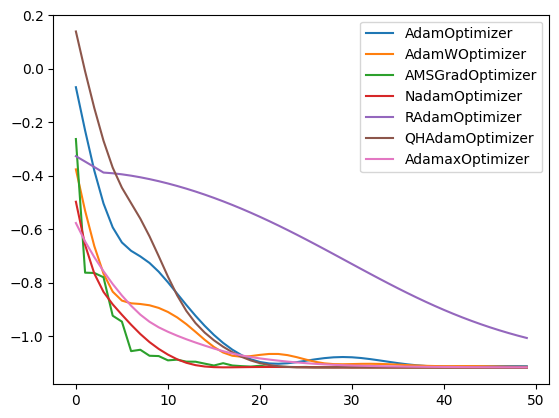

In [15]:
import matplotlib.pyplot as plt
for j, optimizer_func in enumerate(optimizer_funcs):
    plt.plot(costss[j][:50], label = optimizer_func.__name__)
plt.legend()

In [17]:
symbols = ["H", "H"]
num_qubits = 3
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

dev = qml.device("default.mixed", wires=qubits)
num_layers = 2
chain_zxz_pennylane_func = chain_zxz_pennylane(num_qubits, num_layers)
thetas = nps.random.uniform(0, 2*nps.pi, 4 * num_qubits * num_layers)

@qml.qnode(dev, diff_method="parameter-shift")
def cost_fn(thetas):
	qml.Hadamard(wires=0)
	for i in range(0, num_qubits-1):
		qml.CNOT(wires=[i,i+1])
	# for i in range(num_qubits):
	# 	qml.DepolarizingChannel(p=0.05, wires=i)  # Noise probability
	return qml.probs(wires=range(num_qubits))
print(cost_fn(thetas))
drawer = qml.draw(cost_fn)
print(drawer(thetas))

[0.5 0.  0.  0.  0.  0.  0.  0.5]
0: ──H─╭●────┤ ╭Probs
1: ────╰X─╭●─┤ ├Probs
2: ───────╰X─┤ ╰Probs
